# Pk Emulator

## PCA+InterPol Method

In [1]:
import scipy
import pyccl as ccl
import numpy as np
import pylab as plt
import itertools

import pymaster as nmt
from numpy import linalg
from sklearn.decomposition import PCA

class Log_lin_Pk_emulator:
    def __init__(self, n_train, n_k, n_evecs, new = False):
        
        self.n_evecs = n_evecs
        self.k_arr = np.logspace(-4.7,5, n_k)
        self.wc_arr  = np.linspace(0.1, 1, n_train)
        self.h_arr  = np.linspace(0.6,  0.9, n_train)
        
        if new:
            self.grid = []
            for i in range(len(self.wc_arr)):
                for j in range(len(self.h_arr)):
                    self.grid.append(self._get_theory_Pk(self.wc_arr[i], self.h_arr[j]))
            self.grid = np.array(self.grid)
                
            np.savetxt('Pk_grid.txt', self.grid)
        else:
            self.grid = np.loadtxt('Pk_grid.txt')
        
        self.log_grid = np.log(self.grid)
        self.mean_log_grid = np.mean(np.log(self.grid), axis=0) #avg over all cosmologies
        self.clean_grid = self.log_grid - self.mean_log_grid
        
        self.evecs = None
        self.w_arr = None
        self.w_emulator = None
        
        
        
        return 
            
    
    def get_evecs(self, manual = False):
        if self.evecs is None:
            if not manual:
                print('Manual:', manual)
                pca = PCA(n_components=self.n_evecs)
                self.evecs = pca.fit_transform(np.transpose(self.clean_grid))
                #w1 = np.array(np.ones(len(self.k_arr)))
                #self.evecs = np.insert(np.transpose(self.evecs), 0, [w1], axis=0)
                self.evecs = np.transpose(self.evecs)
            else:
                print('Manual:', manual)
                cov = np.cov(np.transpose(self.clean_grid))
                self.evals, self.evecs = linalg.eig(cov)
                self.evecs = self.evecs#*self.evals
                print(self.evals)
                
        return self.evecs

    
    def get_w_arr(self):
        if self.w_arr is None:
            self.w_arr = []
            for i in range(len(self.wc_arr)):
                row = []
                for j in range(len(self.h_arr)):
                    Pk_ij = self._get_theory_Pk(self.wc_arr[i], self.h_arr[j])
                    w_ij = self._get_weigths(Pk_ij)
                    row.append(w_ij)
                self.w_arr.append(row)
                
        self.w_arr = np.transpose(np.array(self.w_arr))       
        return self.w_arr
    
    def get_w_emulator(self):
        if self.w_emulator is None:
            self.w_emulator={}
            w =0
            for grid in self.w_arr:
                w_i_emulator = scipy.interpolate.interp2d( self.wc_arr, self.h_arr, grid, kind='cubic')
                self.w_emulator["w_{}".format(w)]= w_i_emulator
                w = w+1
        return self.w_emulator
    
    def _get_weigths(self, Pk):
        y = np.log(Pk) - self.mean_log_grid
        return np.linalg.lstsq(self.evecs, y, rcond=None)[0]
        
    def _get_theory_Pk(self, wc, h):
        cosmo = ccl.Cosmology(Omega_c=wc, Omega_b=0.049, h=h, sigma8=0.81, n_s=0.96)
        return ccl.power.linear_matter_power(cosmo, self.k_arr, 1)
        
    def _get_evec_Pk(self, weigths , evecs, mean):
        return mean + np.sum(evecs*weigths, axis=1) 
    
    def get_emulated_Pk(self, h, wc):
        #log lin_Pk
        w_vec = []
        for i in range(len(self.evecs)):
            w_i=self.w_emulator["w_{}".format(i)](h, wc)[0]
            w_vec.append(w_i)
        w_vec = np.array(w_vec) 
        Pk = self._get_evec_Pk(w_vec, self.evecs, self.mean_log_grid)
        return self.k_arr, np.array(Pk)
    
    

In [3]:
log_test = Log_lin_Pk_emulator(10, 200, 10, new=True)

In [4]:
log_evecs = log_test.get_evecs(manual = True);

Manual: True
[ 3.16354917e+02+0.00000000e+00j  7.19942782e+00+0.00000000e+00j
  1.03115114e+00+0.00000000e+00j  2.85317343e-02+0.00000000e+00j
  6.37552383e-03+0.00000000e+00j  2.91736260e-03+0.00000000e+00j
  1.31784590e-03+0.00000000e+00j  4.08226373e-04+0.00000000e+00j
  2.48203338e-04+0.00000000e+00j  1.19136111e-04+0.00000000e+00j
  1.00586097e-04+0.00000000e+00j  2.32670642e-05+0.00000000e+00j
  2.19138907e-05+0.00000000e+00j  9.78911818e-06+0.00000000e+00j
  4.81189298e-06+0.00000000e+00j  2.67243698e-06+0.00000000e+00j
  1.55303396e-06+0.00000000e+00j  1.07880525e-06+0.00000000e+00j
  5.99187075e-07+0.00000000e+00j  3.09242342e-07+0.00000000e+00j
  2.49124234e-07+0.00000000e+00j  1.96201894e-07+0.00000000e+00j
  1.43612397e-07+0.00000000e+00j  1.00015690e-07+0.00000000e+00j
  7.33279914e-08+0.00000000e+00j  4.11397701e-08+0.00000000e+00j
  2.94724712e-08+0.00000000e+00j  2.29459256e-08+0.00000000e+00j
  2.08883196e-08+0.00000000e+00j  1.49889719e-08+0.00000000e+00j
  1.15365499

In [5]:
log_test.get_w_arr();

In [8]:
log_test.get_w_emulator()

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:231: ComplexWarning: Casting complex values to real discards the imaginary part
  nx, tx, ny, ty, c, fp, ier = dfitpack.regrid_smth(


{'w_0': <scipy.interpolate.interpolate.interp2d at 0x7f9470458640>,
 'w_1': <scipy.interpolate.interpolate.interp2d at 0x7f9470458160>,
 'w_2': <scipy.interpolate.interpolate.interp2d at 0x7f9470458280>,
 'w_3': <scipy.interpolate.interpolate.interp2d at 0x7f93f4939af0>,
 'w_4': <scipy.interpolate.interpolate.interp2d at 0x7f93f2c6cd30>,
 'w_5': <scipy.interpolate.interpolate.interp2d at 0x7f93f2c6c6d0>,
 'w_6': <scipy.interpolate.interpolate.interp2d at 0x7f93f2c6c670>,
 'w_7': <scipy.interpolate.interpolate.interp2d at 0x7f93f2c6caf0>,
 'w_8': <scipy.interpolate.interpolate.interp2d at 0x7f93f2c6c790>,
 'w_9': <scipy.interpolate.interpolate.interp2d at 0x7f93f2c6c640>,
 'w_10': <scipy.interpolate.interpolate.interp2d at 0x7f93f2c6c970>,
 'w_11': <scipy.interpolate.interpolate.interp2d at 0x7f93f2c6c850>,
 'w_12': <scipy.interpolate.interpolate.interp2d at 0x7f93f2c6c8b0>,
 'w_13': <scipy.interpolate.interpolate.interp2d at 0x7f93f2c6cee0>,
 'w_14': <scipy.interpolate.interpolate.inte

In [15]:
k_arr, log_emulated = log_test.get_emulated_Pk(0.27,0.67 )
log_emulated = np.exp(log_emulated)

In [16]:
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.049, h=0.67, sigma8=0.81, n_s=0.96)
theory  = ccl.power.linear_matter_power(cosmo, k_arr, 1)

In [17]:
log_Pk_diff = abs(log_emulated-theory)

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


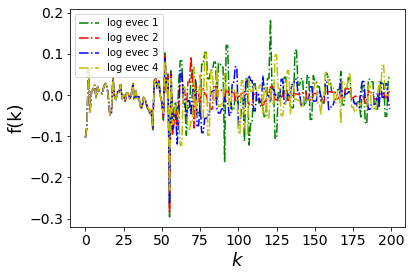

In [18]:
plt.plot(  log_evecs[0] , 'g-.', label = 'log evec 1' )
plt.plot(  log_evecs[1] , 'r-.', label = 'log evec 2' )
plt.plot(  log_evecs[2] , 'b-.', label = 'log evec 3' )
plt.plot(  log_evecs[3] , 'y-.', label = 'log evec 4' )

plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()

/home/zcapjru/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


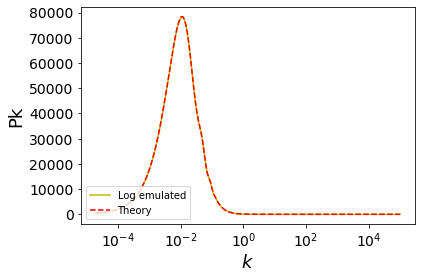

In [19]:
plt.plot(k_arr, log_emulated , 'y-', label = 'Log emulated' )
plt.plot(k_arr, theory, 'r--', label = 'Theory' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Pk',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()

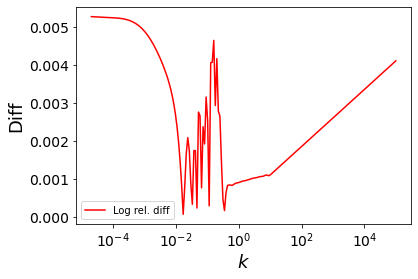

In [20]:
plt.plot(k_arr, log_Pk_diff/theory, 'r-', label = 'Log rel. diff' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Diff',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()

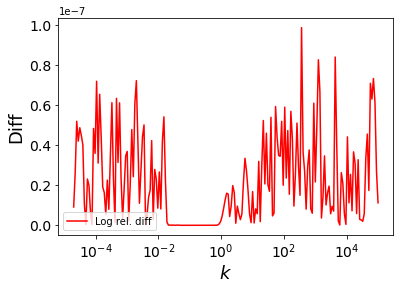

In [14]:
plt.plot(k_arr, log_Pk_diff/theory, 'r-', label = 'Log rel. diff' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('Diff',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
plt.legend(loc="lower left")
plt.show()

# Toy Model

In [30]:
import scipy
import pyccl as ccl
import numpy as np
import pylab as plt
import itertools

import pymaster as nmt
from numpy import linalg
from sklearn.decomposition import PCA

class Toy_emulator:
    def __init__(self, n_train, n_k, n_evecs, new = False):
        
        self.n_evecs = n_k #Complete space
        self.k_arr   = np.linspace(0,100, n_k)
        self.k_mean  = np.mean(self.k_arr)
        self.wc_arr  = np.linspace(0.25, 0.3, n_train)
        self.h_arr   = np.linspace(0.6,  0.9, n_train)
        
        if new:
            self.grid = []
            for i in range(len(self.wc_arr)):
                for j in range(len(self.h_arr)):
                    self.grid.append(self.get_theory(self.wc_arr[i], self.h_arr[j]))
            self.grid = np.array(self.grid)
            np.savetxt('toy_grid.txt', self.grid)
        else:
            self.grid = np.loadtxt('toy_grid.txt')
        
        self.grid_mean = np.mean(self.grid, axis=0)
        self.residues = self.grid-self.grid_mean
        self.evecs = None
        self.hand_evecs = None
        self.w_arr = None
        self.w_emulator = None
        
        
        return 
            
    
    def get_evecs(self, manual = False):
        if self.evecs is None:
            if not manual:
                print('Manual:', manual)
                pca = PCA(n_components=self.n_evecs) 
                self.evecs = pca.fit_transform(np.transpose(self.residues))
                #w1 = np.array(np.ones(len(self.k_arr)))
                #self.evecs = np.insert(np.transpose(self.evecs), 0, [w1], axis=0)
                self.evecs = np.transpose(self.evecs)
            else: 
                print('Manual:', manual)
                cov = np.cov(np.transpose(self.residues))
                self.evals, self.evecs = linalg.eig(cov)
                self.evecs = self.evecs*self.evals
                print(self.evals)
                
        return self.evecs
       
    def get_w_arr(self):
        if self.w_arr is None:
            self.w_arr = []
            for i in range(len(self.wc_arr)):
                row = []
                for j in range(len(self.h_arr)):
                    f_k_ij = self.get_theory(self.wc_arr[i], self.h_arr[j]) - self.grid_mean
                    w_ij = self._get_weigths(f_k_ij)
                    row.append(w_ij)
                self.w_arr.append(row)
                
        self.w_arr = np.transpose(np.array(self.w_arr))       
        return self.w_arr
    
    def get_w_emulator(self):
        if self.w_emulator is None:
            self.w_emulator={}
            w = 0
            for w_i in self.w_arr:
                w_i_emulator = scipy.interpolate.interp2d( self.wc_arr, self.h_arr, w_i, kind='cubic')
                                                #interp2d( x(column coor), y(row coor), w_i, kind='cubic')
                self.w_emulator["w_{}".format(w)]= w_i_emulator
                w = w+1
        return self.w_emulator
    
    def _get_weigths(self, target):
        return np.linalg.lstsq(self.evecs, target, rcond=None)[0]
        
    def get_theory(self, wc, h):
        return h + wc*(self.k_arr-self.k_mean/2)
        
    def _get_predict(self, weigths , evecs):
        return self.grid_mean + np.sum(evecs*weigths, axis=1) 
    
    def get_emulated_f(self, h, wc):
        #log lin_Pk
        w_vec = []
        for i in range(len(self.evecs)): # n_evecs
            w_i=self.w_emulator["w_{}".format(i)](h, wc)[0]
            w_vec.append(w_i)
        w_vec = np.array(w_vec) 
        f_k = self._get_predict(w_vec, self.evecs)
        return self.k_arr, np.array(f_k)
    
    

In [60]:
toy = Toy_emulator(10, 10, None, new= True)

In [61]:
evecs = np.transpose(toy.get_evecs(manual = True))

Manual: True
[ 4.26284839e+00  5.69008863e-02 -6.14316306e-16  5.35123458e-16
  2.35698171e-16  1.17711470e-16 -1.70319940e-16 -7.58292908e-17
 -2.14778244e-17 -4.50399550e-18]


In [62]:
w_arr = toy.get_w_arr()

In [63]:
toy.get_w_emulator()

{'w_0': <scipy.interpolate.interpolate.interp2d at 0x7fd31bfc8f40>,
 'w_1': <scipy.interpolate.interpolate.interp2d at 0x7fd330153f70>,
 'w_2': <scipy.interpolate.interpolate.interp2d at 0x7fd31bfc8c70>,
 'w_3': <scipy.interpolate.interpolate.interp2d at 0x7fd31bfc8b50>,
 'w_4': <scipy.interpolate.interpolate.interp2d at 0x7fd31bfcc670>,
 'w_5': <scipy.interpolate.interpolate.interp2d at 0x7fd31bfcc580>,
 'w_6': <scipy.interpolate.interpolate.interp2d at 0x7fd31bfccfa0>,
 'w_7': <scipy.interpolate.interpolate.interp2d at 0x7fd33005db50>,
 'w_8': <scipy.interpolate.interpolate.interp2d at 0x7fd3301c8b50>,
 'w_9': <scipy.interpolate.interpolate.interp2d at 0x7fd3301c85b0>}

In [64]:
k_arr, emulated = toy.get_emulated_f(0.27,0.67 )
theory = toy.get_theory(0.27, 0.67)

In [65]:
len(emulated)

10

In [66]:
theory

array([-6.08, -3.08, -0.08,  2.92,  5.92,  8.92, 11.92, 14.92, 17.92,
       20.92])

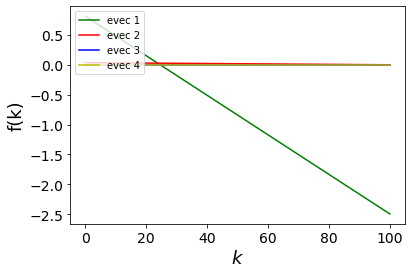

In [67]:
plt.plot( k_arr, evecs[0] , 'g-', label = 'evec 1' )
plt.plot( k_arr, evecs[1] , 'r-', label = 'evec 2' )
plt.plot( k_arr, evecs[2] , 'b-', label = 'evec 3' )
plt.plot( k_arr, evecs[3] , 'y-', label = 'evec 4' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()

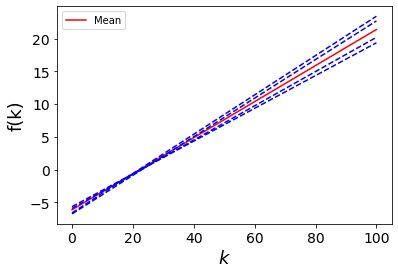

In [68]:
plt.plot( k_arr, toy.grid_mean*np.ones(len(k_arr)) , 'r-', label = 'Mean' )
plt.plot( k_arr, toy.grid[0] , 'b--' )
plt.plot( k_arr, toy.grid[20] , 'b--' )
plt.plot( k_arr, toy.grid[-20] , 'b--' )
plt.plot( k_arr, toy.grid[-1] , 'b--' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()

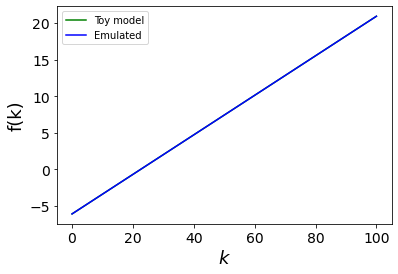

In [69]:
plt.plot(k_arr, theory , 'g-', label = 'Toy model' )
plt.plot(k_arr, emulated , 'b-', label = 'Emulated' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()

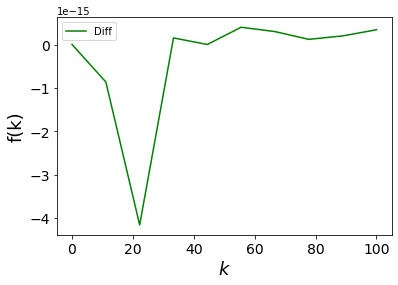

In [70]:
plt.plot(k_arr, np.abs(theory-emulated)/ theory, 'g-', label = 'Diff' )
plt.xlabel('$k$',fontsize=18)
plt.ylabel('f(k)',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="upper left")
plt.show()